In [1]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from facenet_pytorch import MTCNN
from PIL import Image
from functions import MyModel
import matplotlib.pyplot as plt
%matplotlib inline

import shutil
import yaml
import os
from glob import glob
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cuda


In [2]:
config = yaml.safe_load(open('config.yaml'))

In [4]:
mtcnn = MTCNN(
        image_size=config['CROP_OUTPUT_SIZE'], margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=device
    )

Чтобы распознать изображения, их нужно положить в папку тест, а затем запустить ячейки ниже.  
Создастся папка с вырезанными лицами и применится модель.

In [5]:
test_images = glob('test/*')
os.mkdir('test_cropped')
for img_file in test_images:
    img = Image.open(img_file).resize((512, 512)).convert('RGB')
    img_cropped = mtcnn(img, save_path='test_cropped/'+img_file[5:])
del mtcnn

/home/lonelits/anaconda3/envs/severstal_cv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
def image_loader(transformer, image_name):
    image = Image.open(image_name)
    image = transformer(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [7]:
transformer = transforms.Compose([        
    transforms.ToTensor(),                      
    transforms.Normalize(config['image_mean'], config['image_std'])
])

In [ ]:
with open('model_faces.ckpt', 'rb') as f:
    model = torch.load(f)
model.to(device)

Ниже отрисованы 6 фото с вероятностями принадлежности к полу. Плохо распознает корейского парня, но все-таки относит к мужчинам.

/tmp/ipykernel_22599/585427520.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


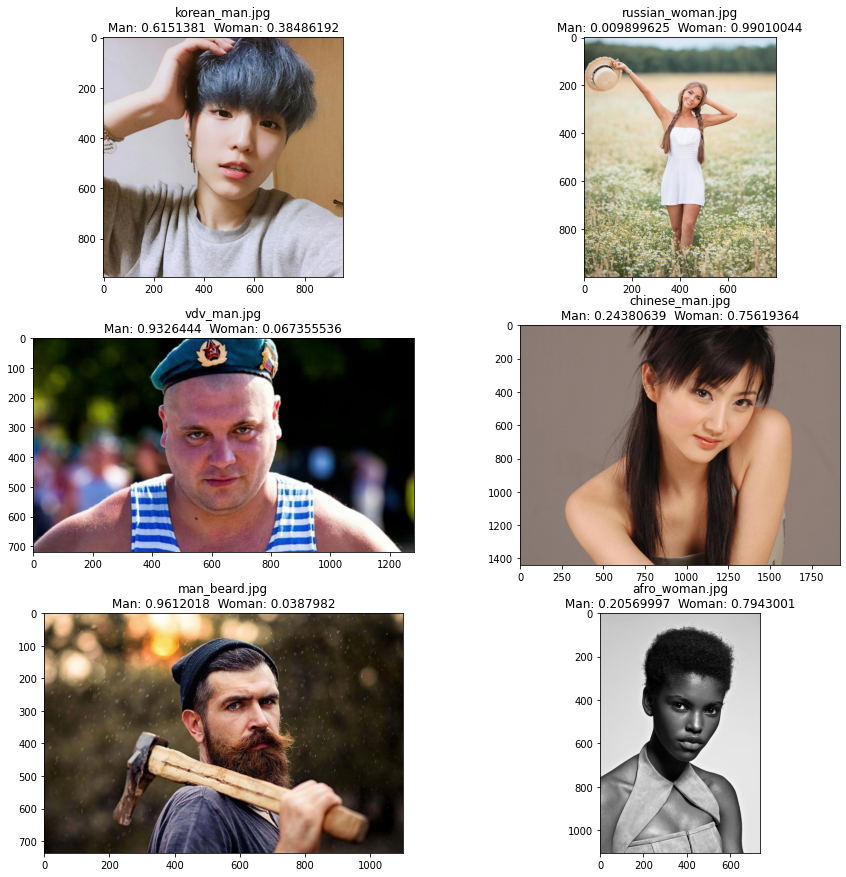

In [17]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=3, ncols=2)
axes = axes.ravel()
for i in range(6):
    img = image_loader(transformer, 'test_cropped/'+test_images[i][5:])
    img = img.to(device)
    axes[i].imshow(Image.open(test_images[i]).convert('RGB'))
    preds = F.softmax(model(img), 1).detach().cpu().numpy()[0]
    axes[i].set_title(test_images[i][5:]+'\nMan: '+str(preds[0])+\
                      '  Woman: '+str(preds[1]))

In [18]:
# удалим папку
shutil.rmtree('test_cropped')